In [1]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import KFold
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load MNIST Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

(60000, 28, 28)
(60000,)
(41935, 28, 28)
(41935,)


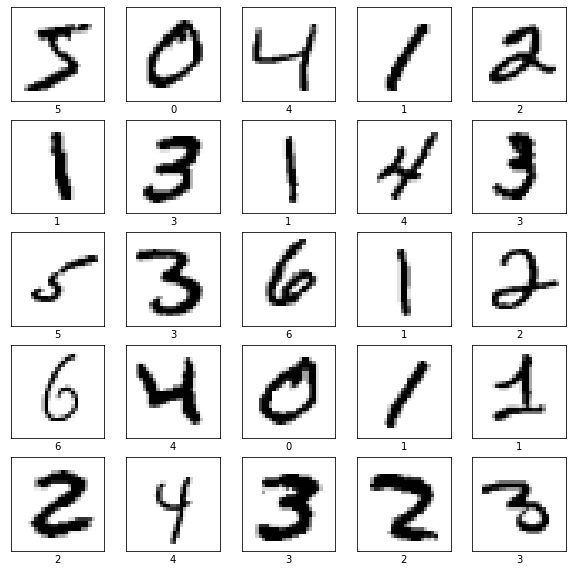

In [3]:
#Filter all Images with classes from 0-6 from dataset for part1
truth_array = (y_train==0) | (y_train==1) | (y_train==2) | (y_train==3) | (y_train==4) | (y_train==5)| (y_train==6)
truth_array_test = (y_test==0) | (y_test==1) | (y_test==2) | (y_test==3) | (y_test==4) | (y_test==5)| (y_test==6)

print(x_train.shape)
print(y_train.shape)

x_teil1 = x_train[truth_array]
dt = np.dtype(np.uint8)
y_teil1=np.array([], dtype=dt)


for value in y_train:
    if value < 7:
        y_teil1 = np.append(y_teil1, value)

print(x_teil1.shape)
print(y_teil1.shape)

x_test1 = x_test[truth_array_test]
dt = np.dtype(np.uint8)
y_test1=np.array([], dtype=dt)

for value in y_test:
    if value < 7:
        y_test1 = np.append(y_test1, value)

#Normalize pixel values to be between 0 and 1
x_teil1 = x_teil1 / 255.0 - 0.5
x_test1 = x_test1 / 255.0 - 0.5

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_teil1[i], cmap=plt.cm.binary)
    plt.xlabel(y_teil1[i])
plt.show()

y_teil1 = y_teil1.reshape(y_teil1.shape[0], 1)
x_teil1 = x_teil1.reshape(x_teil1.shape[0], x_teil1.shape[1], x_teil1.shape[2], 1)

y_test1 = y_test1.reshape(y_test1.shape[0], 1)
x_test1 = x_test1.reshape(x_test1.shape[0], x_test1.shape[1], x_test1.shape[2], 1)

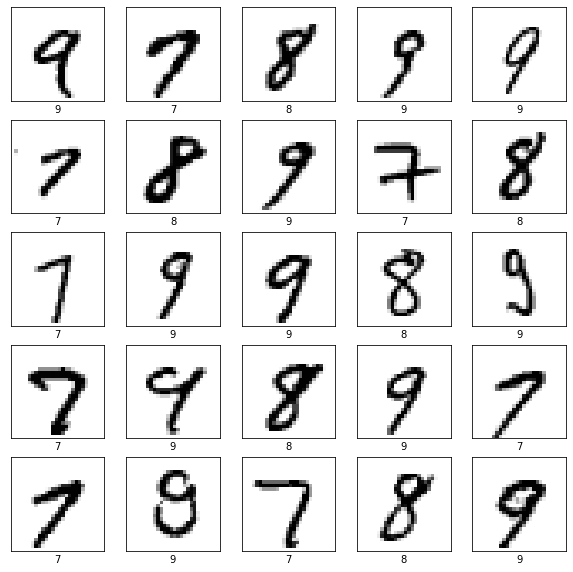

In [4]:
#Filter all Images with classes from 7-9 from dataset for part2
truth_array2 = (y_train==7) | (y_train==8) | (y_train==9)
truth_array2_test = (y_test==7) | (y_test==8) | (y_test==9)

x_teil2 = x_train[truth_array2]
dt = np.dtype(np.uint8)
y_teil2=np.array([], dtype=dt)


for value in y_train:
    if value > 6:
        y_teil2 = np.append(y_teil2, value)

#print(x_teil2.shape)
#print(y_teil2.shape)

x_test2 = x_test[truth_array2_test]
dt = np.dtype(np.uint8)
y_test2=np.array([], dtype=dt)

for value in y_test:
    if value > 6:
        y_test2 = np.append(y_test2, value)

#Normalize pixel values to be between 0 and 1
x_teil2 = x_teil2 / 255.0 - 0.5
x_test2 = x_test2 / 255.0 - 0.5

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_teil2[i], cmap=plt.cm.binary)
    plt.xlabel(y_teil2[i])
plt.show()

y_teil2 = y_teil2.reshape(y_teil2.shape[0], 1)
x_teil2 = x_teil2.reshape(x_teil2.shape[0], x_teil2.shape[1], x_teil2.shape[2], 1)

y_test2 = y_test2.reshape(y_test2.shape[0], 1)
x_test2 = x_test2.reshape(x_test2.shape[0], x_test2.shape[1], x_test2.shape[2], 1)

#inputs and targets for kFold training set
inputs = x_teil2
targets = y_teil2

In [5]:
#Create and Train the Base Model with MNIST 0-6
#Quelle
#Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
#https://www.tensorflow.org/guide/keras/sequential_model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(200,activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(200,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

model.summary()

#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Quelle
#https://www.tensorflow.org/guide/keras/train_and_evaluate

history = model.fit(
    x_teil1,
    y_teil1,
    epochs=50,
    batch_size=128,
    validation_data=(x_test1, y_test1),
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Epoch 46/50
328/328 [==============================] - 2s 7ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0209 - val_accuracy: 0.9959
Epoch 47/50
328/328 [==============================] - 2s 7ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0159 - val_accuracy: 0.9963
Epoch 48/50
328/328 [==============================] - 2s 7ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0145 - val_accuracy: 0.9964
Epoch 49/50
328/328 [==============================] - 2s 7ms/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0222 - val_accuracy: 0.9957
Epoch 50/50
328/328 [==============================] - 2s 7ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0174 - val_accuracy: 0.9957


In [6]:
# Save the entire model for Transfer Learning
!mkdir -p saved_models_mnist
model.save('saved_models_mnist/base_model_mnist0-6')

INFO:tensorflow:Assets written to: saved_models_mnist/base_model_mnist0-6/assets


In [7]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning
def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

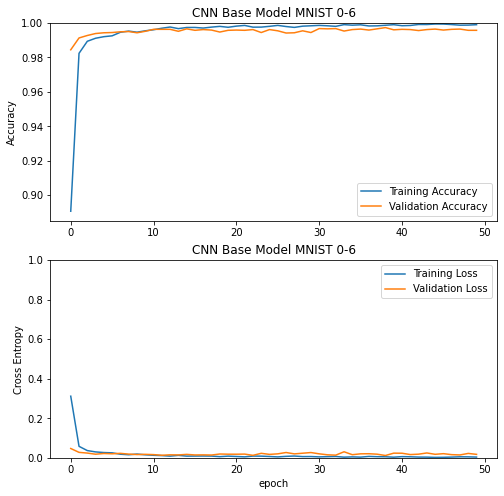

In [8]:
# Display training curve 
display_history(history, "CNN Base Model MNIST 0-6")

5


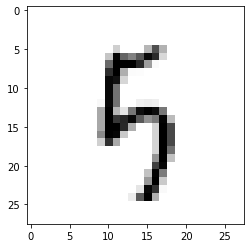

In [9]:
y=model.predict(x_test1)
print(np.argmax(y[1500]))
plt.imshow(x_test1[1500], cmap=plt.cm.binary)

In [11]:
# Evaluate model accuracy
loss, acc = model.evaluate(x_test1, y_test1, verbose=2)
print('Accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(x_test1).shape)

219/219 - 1s - loss: 0.0116 - accuracy: 0.9973
Accuracy: 99.73%
(3011, 10)


<h2>Transfer Learning

In [2]:
# Load the Model for Transfer Learning
new_model = tf.keras.models.load_model('saved_models_mnist/base_model_mnist0-6')

#Freeze the layers on the model
new_model.trainable = False

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [13]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test1, y_test1, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(x_test1).shape)

219/219 - 1s - loss: 0.0116 - accuracy: 0.9973
Restored model, accuracy: 99.73%
(6989, 10)


<h2>Add a classifier head</h2>

Create a new model by adding a classifier on top of the base model.

In [3]:
#Quelle
#https://github.com/PacktPublishing/Hands-On-Transfer-Learning-with-TensorFlow-2.0-Video
def build_mnist_model(base_model):
  model = tf.keras.models.Sequential()
  for layer in base_model.layers[:-4]:
        layer.trainable = False
        model.add(layer)
        print('Layer ' + layer.name + ' frozen.')
  model.add(tf.keras.layers.Dense(200,activation='relu')),
  model.add(tf.keras.layers.Dropout(rate=0.5)),
  model.add(tf.keras.layers.Dense(200,activation='relu')),
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

In [4]:
transfer_model = build_mnist_model(new_model)

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.
Layer conv2d_3 frozen.
Layer max_pooling2d_1 frozen.
Layer flatten frozen.


In [5]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [6]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [ ]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for MNIST 7-9
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model
    transfer_model = build_mnist_model(new_model)
    
    #LearningRate WarmUp -> kein Erfolg-> schriftlich festhalten dass wir neu trainiert haben    
    transfer_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    
    checkpoint_filepath = f'tmp/tl_checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate
    #Transfer Learning of the Model with MNIST Dataset 7-9
    history = transfer_model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback]
    )

    #model.load_weights(checkpoint_filepath)
    # Generate generalization metrics
    scores = transfer_model.evaluate(inputs[test], targets[test], verbose=0)
    print(transfer_model.metrics_names)
    print(f'Score for fold {fold_no}: {transfer_model.metrics_names[0]} of {scores[0]}; {transfer_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    transfer_model.save(f'saved_models_mnist_kfold/tl_model_mnist7-9_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [19]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_mnist_kfold/tl_model_mnist7-9_{i}')
    model.load_weights(f'tmp/tl_checkpoint{i}')

    loss, acc = model.evaluate(x_test2, y_test2, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test2).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('tl_accuracy.xlsx', sheet_name='kfold', index=False)

95/95 - 0s - loss: 0.0237 - accuracy: 0.9947
Accuracy: 99.47%
(3011, 10)
95/95 - 0s - loss: 0.0237 - accuracy: 0.9950
Accuracy: 99.50%
(3011, 10)
95/95 - 0s - loss: 0.0240 - accuracy: 0.9950
Accuracy: 99.50%
(3011, 10)
95/95 - 0s - loss: 0.0285 - accuracy: 0.9944
Accuracy: 99.44%
(3011, 10)
95/95 - 0s - loss: 0.0255 - accuracy: 0.9940
Accuracy: 99.40%
(3011, 10)
95/95 - 0s - loss: 0.0219 - accuracy: 0.9934
Accuracy: 99.34%
(3011, 10)
95/95 - 0s - loss: 0.0327 - accuracy: 0.9960
Accuracy: 99.60%
(3011, 10)
95/95 - 0s - loss: 0.0268 - accuracy: 0.9947
Accuracy: 99.47%
(3011, 10)
95/95 - 0s - loss: 0.0265 - accuracy: 0.9960
Accuracy: 99.60%
(3011, 10)
95/95 - 0s - loss: 0.0220 - accuracy: 0.9940
Accuracy: 99.40%
(3011, 10)


In [ ]:
# Display training curve 
display_history(history, "CNN Model MNIST 7-9 after Transfer Learning")

<h2> Fine Tuning

In [7]:
#Load Model for fine tuning and attacking
fine_tune_model = tf.keras.models.load_model(f'saved_models_mnist_kfold/tl_model_mnist7-9_10')
fine_tune_model.load_weights(f'tmp/tl_checkpoint10')

In [8]:
#Unfreeze all Layers und base model
fine_tune_model.trainable = True

In [9]:
#Print number of layers of model
print('Number of layers in the transfer model: ', len(fine_tune_model.layers))

Number of layers in the transfer model:  11


In [10]:
#Quelle
#https://github.com/PacktPublishing/Hands-On-Transfer-Learning-with-TensorFlow-2.0-Video
#fine tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in fine_tune_model.layers[:fine_tune_at]:
  layer.trainable =  False
  print('Layer ' + layer.name + ' frozen.')  

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.


In [11]:
fine_tune_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)            

In [64]:
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [65]:
checkpoint_filepath = 'tmp/ft_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Fine Tuning of the Model with MNIST 7-9 Dataset
history_fine = fine_tune_model.fit(
    x_teil2,
    y_teil2,
    epochs=50,
    batch_size=128,
    validation_data=(x_test2, y_test2),
    callbacks=[model_checkpoint_callback]
)

fine_tune_model.load_weights(checkpoint_filepath)

Epoch 1/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.0210 - val_accuracy: 0.9950
Epoch 2/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0210 - val_accuracy: 0.9954
Epoch 3/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0211 - val_accuracy: 0.9954
Epoch 4/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0209 - val_accuracy: 0.9954
Epoch 5/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0210 - val_accuracy: 0.9957
Epoch 6/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0212 - val_accuracy: 0.9957
Epoch 7/50
142/142 [==============================] - 1s 6ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0211 - val_accuracy: 0.9954
Epoch 

In [ ]:
# Display training curve 
display_history(history_fine, "CNN Model MNIST 7-9 after Fine Tuning")

In [11]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [66]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(fine_tune_model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test2, dtype='int64')
attack_labels = tf.reshape(attack_labels, 3011)
attack_images = tf.convert_to_tensor(x_test2, dtype='float32')

In [67]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox
predictions = fine_tune_model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Clean Accuracy:  99.63 %


In [68]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
#PGD40 mit 20 Restarts, Table1
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 10)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [69]:
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

Success Rate: [0.00365327 0.00398539 0.00398539 0.00398539 0.00398539 0.00398539
 0.0043175  0.00464962 0.00664231 0.15376951 0.26303554 0.3410827
 0.44403853 0.56858187 0.89903686 1.        ]


In [ ]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
accuracy = list()
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.2f} %")
    accuracy.append(acc.item() * 100)
print("---------------------------------------------------------")

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py
#https://github.com/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb
plt.plot(epsilons, robust_accuracy.numpy() * 100)
#plt.plot(epsilon, label='Epsilon')
#plt.legend(loc='upper right')
plt.ylabel('Accuracy in (%)')
plt.title('Robust Accuracy')
plt.xlabel('Epsilon')
plt.show()

#Quelle
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('robust_accuracy.png', dpi=300, bbox_inches='tight')

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
df = pd.DataFrame(accuracy)

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html
df.to_excel('robust_accuracy_mnist_tl.xlsx', sheet_name='attack', index=False)

In [ ]:
#print(raw.shape)
acc = np.zeros(shape=(len(epsilons)))
#for loop über alle epsilons
for i in range(len(epsilons)):
    #print("Labels:      ", np.array(labels))
    print("Epsilon:      ", epsilons[i])
    #foolbox.plot.images(images)
    #plt.show()
    predictions = transfer_model.predict(clipped[i])
    adv_predictions = np.argmax(predictions, axis = 1)
    #print("Predictions: ", adv_predictions) # adversarial prediction
    #foolbox.plot.images(raw[i])
    #plt.show()
    print("Accuracy: ", np.mean(adv_predictions == attack_labels)) # Accuracy of adversarial images
    print("--------------------------------------------------------------")
    print("")
    print("--------------------------------------------------------------")
    acc[i] = np.mean(adv_predictions == attack_labels)
plt.plot(epsilons, acc)

In [ ]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)